In [1]:
!apt-get install graphviz -y
!pip install pydot

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import holidays

### Loading and preparing data

In [3]:
# Load dataset
file_path = "merged_data.csv"
df = pd.read_csv(file_path)

print(df.tail())

        growth_driver_l1    growth_driver_l2    growth_driver_l3  \
2023  ap_consumer_facing  shopper_experience  shopper_experience   
2024  ap_consumer_facing  shopper_experience  shopper_experience   
2025  ap_consumer_facing  shopper_experience  shopper_experience   
2026  ap_consumer_facing  shopper_experience  shopper_experience   
2027  ap_consumer_facing  shopper_experience  shopper_experience   

               growth_driver_l4           growth_driver_l5 metric  \
2023  testers_and_merchandising  testers_and_merchandising  units   
2024  testers_and_merchandising  testers_and_merchandising  units   
2025  testers_and_merchandising  testers_and_merchandising  units   
2026  testers_and_merchandising  testers_and_merchandising  units   
2027  testers_and_merchandising  testers_and_merchandising  units   

     Starting Week  investment (in pound)  execution  Year_x  \
2023    2023-11-27                  0.000        0.0    2023   
2024    2023-12-04                  0.000       

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 18 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   growth_driver_l1                                                      2028 non-null   object 
 1   growth_driver_l2                                                      2028 non-null   object 
 2   growth_driver_l3                                                      2028 non-null   object 
 3   growth_driver_l4                                                      2028 non-null   object 
 4   growth_driver_l5                                                      2028 non-null   object 
 5   metric                                                                2028 non-null   object 
 6   Starting Week                                                         2028 non-null   object 
 7

In [5]:
print(df.describe())

       investment (in pound)     execution       Year_x  \
count            2028.000000  2.028000e+03  2028.000000   
mean            10244.582485  1.034198e+06  2022.512821   
std             33601.093781  2.489482e+06     0.499959   
min                 0.000000  0.000000e+00  2022.000000   
25%                 0.000000  0.000000e+00  2022.000000   
50%                 0.000000  0.000000e+00  2023.000000   
75%              7057.888494  8.712067e+05  2023.000000   
max            399110.517000  3.101082e+07  2023.000000   

       UK L'Oreal Paris Haircare Offline Average Price (in pound)  \
count                                        2028.000000            
mean                                            2.857848            
std                                             0.285731            
min                                             2.323822            
25%                                             2.526715            
50%                                             2.9606

In [6]:
df["Starting Week"] = pd.to_datetime(df["Starting Week"])
df = df.sort_values("Starting Week")
print(df["Starting Week"].min(), df["Starting Week"].max())

2022-01-03 00:00:00 2023-12-25 00:00:00


In [7]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns

for col in non_numeric_cols:
    print(f"Unique values in column '{col}':")
    print(df[col].unique())

Unique values in column 'growth_driver_l1':
['ap_consumer_facing']
Unique values in column 'growth_driver_l2':
['consumer_engagement' 'shopper_experience']
Unique values in column 'growth_driver_l3':
['advocacy_media' 'shopper_experience' 'paid_media']
Unique values in column 'growth_driver_l4':
['influencer_management' 'testers_and_merchandising'
 'online_multiformat_ads_transaction' 'online_video_content_platforms'
 'traditional_tv' 'paid_search_awarenessconsideration'
 'paid_search_transaction' 'social_media_transaction'
 'social_media_awarenessconsideration' 'digital_tv']
Unique values in column 'growth_driver_l5':
['influencer_management' 'testers_and_merchandising' 'tesco'
 'google_video' 'youtube' 'linear' 'google' 'amazon' 'citrus' 'tik_tok'
 'criteo' 'meta' 'pinterest' 'the_hut_group' 'meta_collab_ads'
 'amazon_retail' 'bvod']
Unique values in column 'metric':
['engagements' 'units' 'impressions' 'grps']
Unique values in column 'Starting Week':
<DatetimeArray>
['2022-01-03 00:

In [8]:
if (df["Year_x"] == df["Year_y"]).all():
    print("✅ `Year_x` and `Year_y` are the same. Deleting `Year_y`.")
    df = df.drop(columns=["Year_y"])
    df = df.rename(columns={"Year_x": "Year"})
else:
    print("⚠️ `Year_x` and `Year_y` are not the same.")
    print(df[["Year_x", "Year_y"]].drop_duplicates())

✅ `Year_x` and `Year_y` are the same. Deleting `Year_y`.


### Data viz and extracting dataset for online

<ipython-input-9-2fb024f999d3>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edges = edges.applymap(lambda x: x.replace("_", " ") if pd.notna(x) else x)
<ipython-input-9-2fb024f999d3>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notna(row[i]) and pd.notna(row[i + 1]):
<ipython-input-9-2fb024f999d3>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G.add_edge(row[i], row[i + 1])


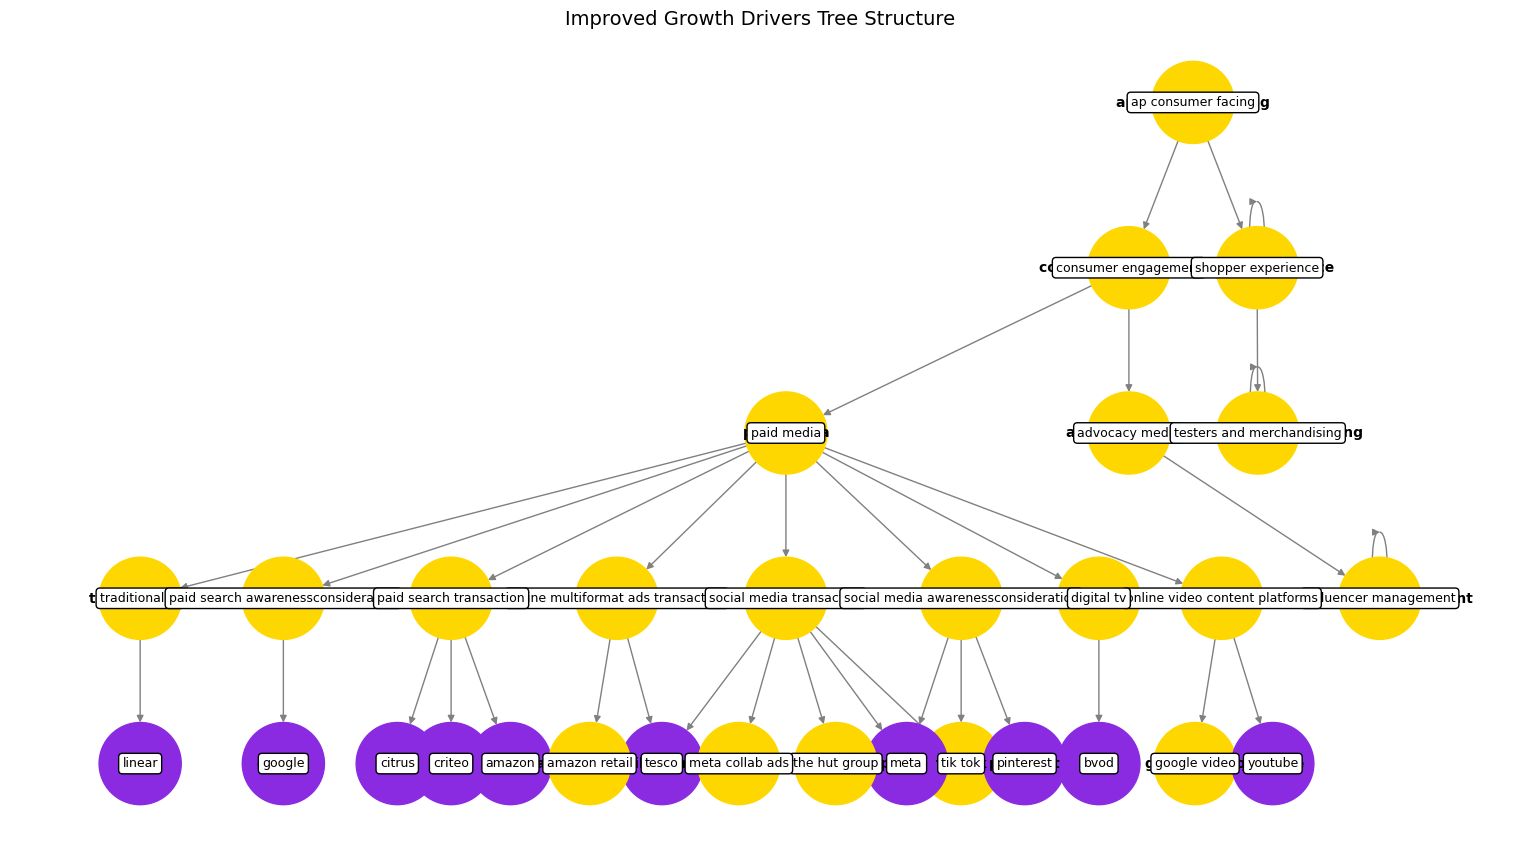

In [9]:
# Extract unique relationships between growth driver levels
edges = df[["growth_driver_l1", "growth_driver_l2", "growth_driver_l3", "growth_driver_l4", "growth_driver_l5"]].drop_duplicates()

# Replace underscores with spaces for readability
edges = edges.applymap(lambda x: x.replace("_", " ") if pd.notna(x) else x)

# Initialize directed graph
G = nx.DiGraph()

# Add edges to the graph
for _, row in edges.iterrows():
    for i in range(4):  # Connecting L1 → L2 → L3 → L4 → L5
        if pd.notna(row[i]) and pd.notna(row[i + 1]):
            G.add_edge(row[i], row[i + 1])

# Define improved colors for different levels
level_colors = {
    0: "#FFD700",  # Gold (L1)
    1: "#FF6347",  # Tomato (L2)
    2: "#4682B4",  # Steel Blue (L3)
    3: "#32CD32",  # Lime Green (L4)
    4: "#8A2BE2"   # Blue Violet (L5)
}

# Assign colors based on hierarchy depth
node_colors = []
for node in G.nodes():
    depth = next((i for i, col in enumerate(["growth_driver_l1", "growth_driver_l2", "growth_driver_l3", "growth_driver_l4", "growth_driver_l5"]) if node in df[col].unique()), 0)
    node_colors.append(level_colors.get(depth, "#A9A9A9"))  # Default to Dark Gray if unknown

# Use graphviz layout for clearer spacing
plt.figure(figsize=(15, 8))
pos = graphviz_layout(G, prog="dot")  # "dot" ensures top-down tree structure

# Draw the tree with larger spacing and adjusted label positioning
nx.draw(
    G, pos, with_labels=True, node_color=node_colors, node_size=3500,
    edge_color="gray", font_size=10, font_weight="bold", arrows=True
)

# Rotate labels slightly to prevent overlap
for label in pos:
    x, y = pos[label]
    plt.text(x, y, label, fontsize=9, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.title("Improved Growth Drivers Tree Structure", fontsize=14)
plt.show()


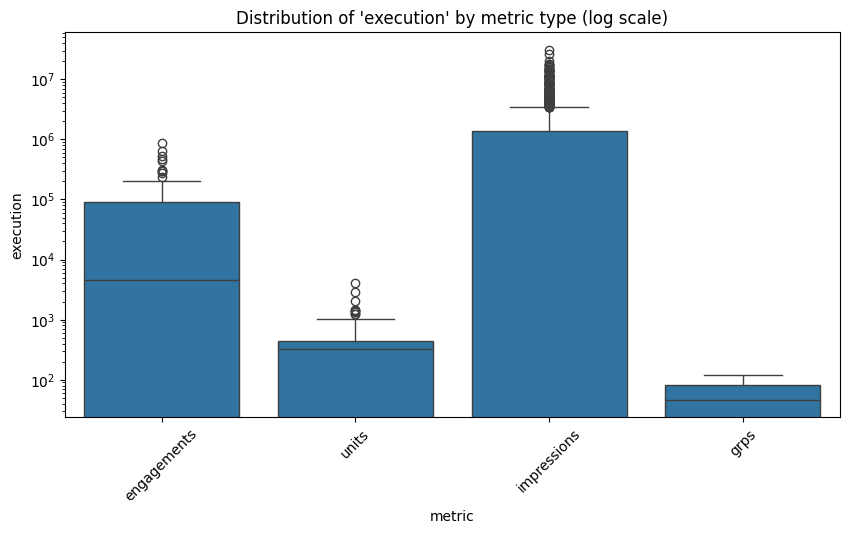

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["metric"], y=df["execution"])
plt.yscale("log")
plt.title("Distribution of 'execution' by metric type (log scale)")
plt.xticks(rotation=45)
plt.show()

In [11]:
# Filter only rows related to Online Growth Drivers
online_df = df.copy()

# Keep relevant Online KPIs
online_df = online_df[
    [
        "Starting Week",
        "Year",
        "growth_driver_l1",
        "growth_driver_l2",
        "growth_driver_l3",
        "growth_driver_l4",
        "growth_driver_l5",
        "metric",
        "investment (in pound)",
        "execution",
        "UK L'Oreal Paris Haircare Online Average Price (in pound)",
        "UK L'Oreal Paris Haircare Total Weigheted Promotion Distribution (%)",
        "UK L'Oreal Paris Haircare Total Online Sellout Units"
    ]
]

# Convert date to datetime format
online_df["Starting Week"] = pd.to_datetime(online_df["Starting Week"])

# Sort by date
online_df = online_df.sort_values("Starting Week")

# Check unique values in metric
print("Unique Metrics in Online Data:", online_df["metric"].unique())

# Save for later use
online_df.to_csv("online_dataset.csv", index=False)

online_df.info()

Unique Metrics in Online Data: ['engagements' 'impressions' 'units' 'grps']
<class 'pandas.core.frame.DataFrame'>
Index: 2028 entries, 0 to 2027
Data columns (total 13 columns):
 #   Column                                                                Non-Null Count  Dtype         
---  ------                                                                --------------  -----         
 0   Starting Week                                                         2028 non-null   datetime64[ns]
 1   Year                                                                  2028 non-null   int64         
 2   growth_driver_l1                                                      2028 non-null   object        
 3   growth_driver_l2                                                      2028 non-null   object        
 4   growth_driver_l3                                                      2028 non-null   object        
 5   growth_driver_l4                                                      2028 

In [12]:
# Count occurrences of each date
date_counts = online_df["Starting Week"].value_counts().reset_index()
date_counts.columns = ["Starting Week", "Count"]

# Show dates where we have duplicates
date_counts = date_counts[date_counts["Count"] > 1]
print("Dates with multiple entries:\n", date_counts)
date_counts.describe()

Dates with multiple entries:
     Starting Week  Count
0      2023-10-30     20
1      2023-10-23     20
2      2023-10-16     20
3      2023-10-09     20
4      2023-10-02     20
..            ...    ...
99     2022-12-05     19
100    2022-10-10     19
101    2022-10-17     19
102    2022-10-24     19
103    2022-10-31     19

[104 rows x 2 columns]


,Starting Week,Count
count,104,104.000000
mean,2022-12-29 12:00:00,19.500000
min,2022-01-03 00:00:00,19.000000
25%,2022-07-02 06:00:00,19.000000
50%,2022-12-29 12:00:00,19.500000
75%,2023-06-27 18:00:00,20.000000
max,2023-12-25 00:00:00,20.000000
std,NaN,0.502421


In [13]:
# Pick a random duplicate date
example_date = date_counts.iloc[0]["Starting Week"]  # First date with duplicates

# Show all rows for that date
print(f"Entries for {example_date}:")
display(online_df[online_df["Starting Week"] == example_date])


Entries for 2023-10-30 00:00:00:


,Starting Week,Year,growth_driver_l1,growth_driver_l2,growth_driver_l3,growth_driver_l4,growth_driver_l5,metric,investment (in pound),execution,UK L'Oreal Paris Haircare Online Average Price (in pound),UK L'Oreal Paris Haircare Total Weigheted Promotion Distribution (%),UK L'Oreal Paris Haircare Total Online Sellout Units
823,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,paid_search_transaction,amazon,impressions,4308.876,1688538.800,3.641635,0.86,131939.6
1031,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,paid_search_transaction,criteo,impressions,5206.006,371216.300,3.641635,0.86,131939.6
927,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,paid_search_transaction,citrus,impressions,15173.769,5489381.300,3.641635,0.86,131939.6
2019,2023-10-30,2023,ap_consumer_facing,shopper_experience,shopper_experience,testers_and_merchandising,testers_and_merchandising,units,0.000,0.000,3.641635,0.86,131939.6
511,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,online_video_content_platforms,google_video,impressions,0.000,0.000,3.641635,0.86,131939.6
1915,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,traditional_tv,linear,grps,0.000,0.000,3.641635,0.86,131939.6
1343,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,social_media_awarenessconsideration,tik_tok,impressions,0.000,0.000,3.641635,0.86,131939.6
1135,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,social_media_awarenessconsideration,meta,impressions,2871.544,1174716.400,3.641635,0.86,131939.6
303,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,online_multiformat_ads_transaction,amazon_retail,impressions,0.000,0.000,3.641635,0.86,131939.6
1811,2023-10-30,2023,ap_consumer_facing,consumer_engagement,paid_media,social_media_transaction,tik_tok,impressions,0.000,0.000,3.641635,0.86,131939.6


In [14]:
# Drop Level 1 growth driver since it's constant
online_df = online_df.drop(columns=["growth_driver_l1"], errors="ignore")

# Create a unique identifier for each growth driver combination
online_df["growth_driver_combination"] = (
    online_df["growth_driver_l2"] + " | " +
    online_df["growth_driver_l3"] + " | " +
    online_df["growth_driver_l4"] + " | " +
    online_df["growth_driver_l5"]
)

# Store metric mapping in a dictionary
metric_mapping = online_df.groupby("growth_driver_combination")["metric"].unique().to_dict()

# Identify the columns that remain constant for each date
constant_columns = [
    "UK L'Oreal Paris Haircare Online Average Price (in pound)",
    "UK L'Oreal Paris Haircare Total Weigheted Promotion Distribution (%)",
    "UK L'Oreal Paris Haircare Total Online Sellout Units"
]

# Keep only one unique row per date for these constant columns
constant_data = online_df[["Starting Week", "Year"] + constant_columns].drop_duplicates()

# Pivot execution & investment by growth driver combination
pivot_df = online_df.pivot_table(
    index=["Starting Week", "Year"],
    columns="growth_driver_combination",
    values=["execution", "investment (in pound)"],
    aggfunc="sum",
    fill_value=0
)

# Flatten MultiIndex column names
pivot_df.columns = [f"{col[0]} - {col[1]}" for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()

# Merge back the constant columns
final_df = pd.merge(pivot_df, constant_data, on=["Starting Week", "Year"], how="left")

# Save the cleaned dataset
final_df.to_csv("online_dataset_cleaned.csv", index=False)

In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 45 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype         
---  ------                                                                                                                   --------------  -----         
 0   Starting Week                                                                                                            104 non-null    datetime64[ns]
 1   Year                                                                                                                     104 non-null    int64         
 2   execution - consumer_engagement | advocacy_media | influencer_management | influencer_management                         104 non-null    float64       
 3   execution - consumer_engagement | paid_media | digital_tv | bvod                                         

In [16]:
final_df.head()

,Starting Week,Year,execution - consumer_engagement | advocacy_media | influencer_management | influencer_management,execution - consumer_engagement | paid_media | digital_tv | bvod,execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | amazon_retail,execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco,execution - consumer_engagement | paid_media | online_video_content_platforms | google_video,execution - consumer_engagement | paid_media | online_video_content_platforms | youtube,execution - consumer_engagement | paid_media | paid_search_awarenessconsideration | google,execution - consumer_engagement | paid_media | paid_search_transaction | amazon,...,investment (in pound) - consumer_engagement | paid_media | social_media_transaction | meta,investment (in pound) - consumer_engagement | paid_media | social_media_transaction | meta_collab_ads,investment (in pound) - consumer_engagement | paid_media | social_media_transaction | tesco,investment (in pound) - consumer_engagement | paid_media | social_media_transaction | the_hut_group,investment (in pound) - consumer_engagement | paid_media | social_media_transaction | tik_tok,investment (in pound) - consumer_engagement | paid_media | traditional_tv | linear,investment (in pound) - shopper_experience | shopper_experience | testers_and_merchandising | testers_and_merchandising,UK L'Oreal Paris Haircare Online Average Price (in pound),UK L'Oreal Paris Haircare Total Weigheted Promotion Distribution (%),UK L'Oreal Paris Haircare Total Online Sellout Units
0,2022-01-03,2022,537.216943,0.00,193246.3,0.0,0.0,0.0,4067.7,1468912.9,...,0.0,918.38565,0.0,0.0,0.0,0.0,5303.066526,3.242071,0.37,111888.4
1,2022-01-10,2022,0.000000,0.00,343567.9,0.0,0.0,0.0,3716.7,2474498.0,...,0.0,867.26952,0.0,0.0,0.0,0.0,4418.402838,2.978819,0.42,129334.4
2,2022-01-17,2022,0.000000,0.00,448357.0,0.0,0.0,0.0,4264.0,2691219.7,...,0.0,1019.38005,0.0,0.0,0.0,0.0,6301.752894,3.014039,0.43,119282.8
3,2022-01-24,2022,142432.121596,815102.08,626307.5,0.0,0.0,0.0,4633.2,1940061.5,...,0.0,1101.75156,0.0,0.0,0.0,169674.7,9379.862800,3.077403,0.86,116281.1
4,2022-01-31,2022,95869.369418,679251.82,619993.4,0.0,0.0,0.0,2134.6,2349322.3,...,0.0,987.27993,0.0,0.0,0.0,292321.9,16387.142720,3.306272,0.78,116873.9


### EDA of online data


🔹 Dataset Overview:
Shape: (104, 45)

🔹 Column Types:
Starting Week                                                                                                              datetime64[ns]
Year                                                                                                                                int64
execution - consumer_engagement | advocacy_media | influencer_management | influencer_management                                  float64
execution - consumer_engagement | paid_media | digital_tv | bvod                                                                  float64
execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | amazon_retail                                 float64
execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco                                         float64
execution - consumer_engagement | paid_media | online_video_content_platforms | google_video                         

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


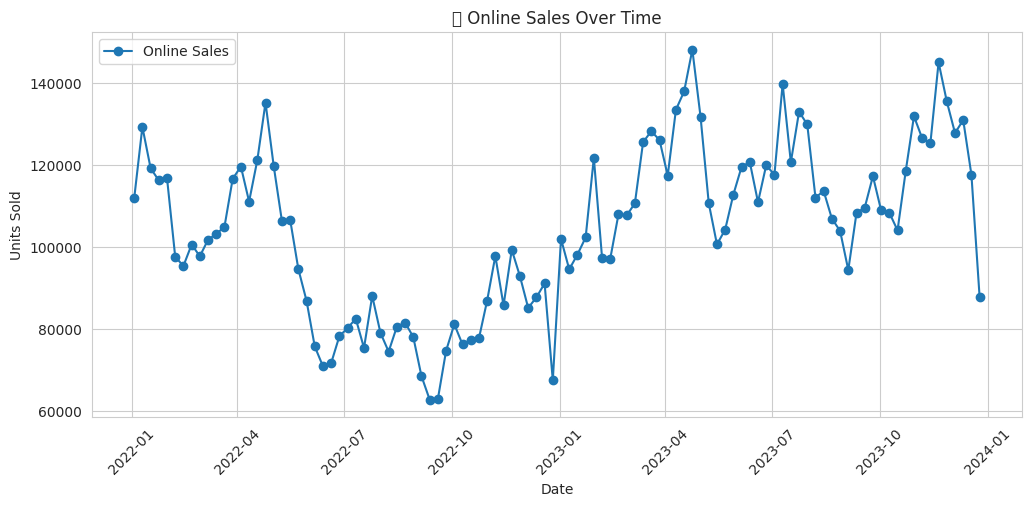

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


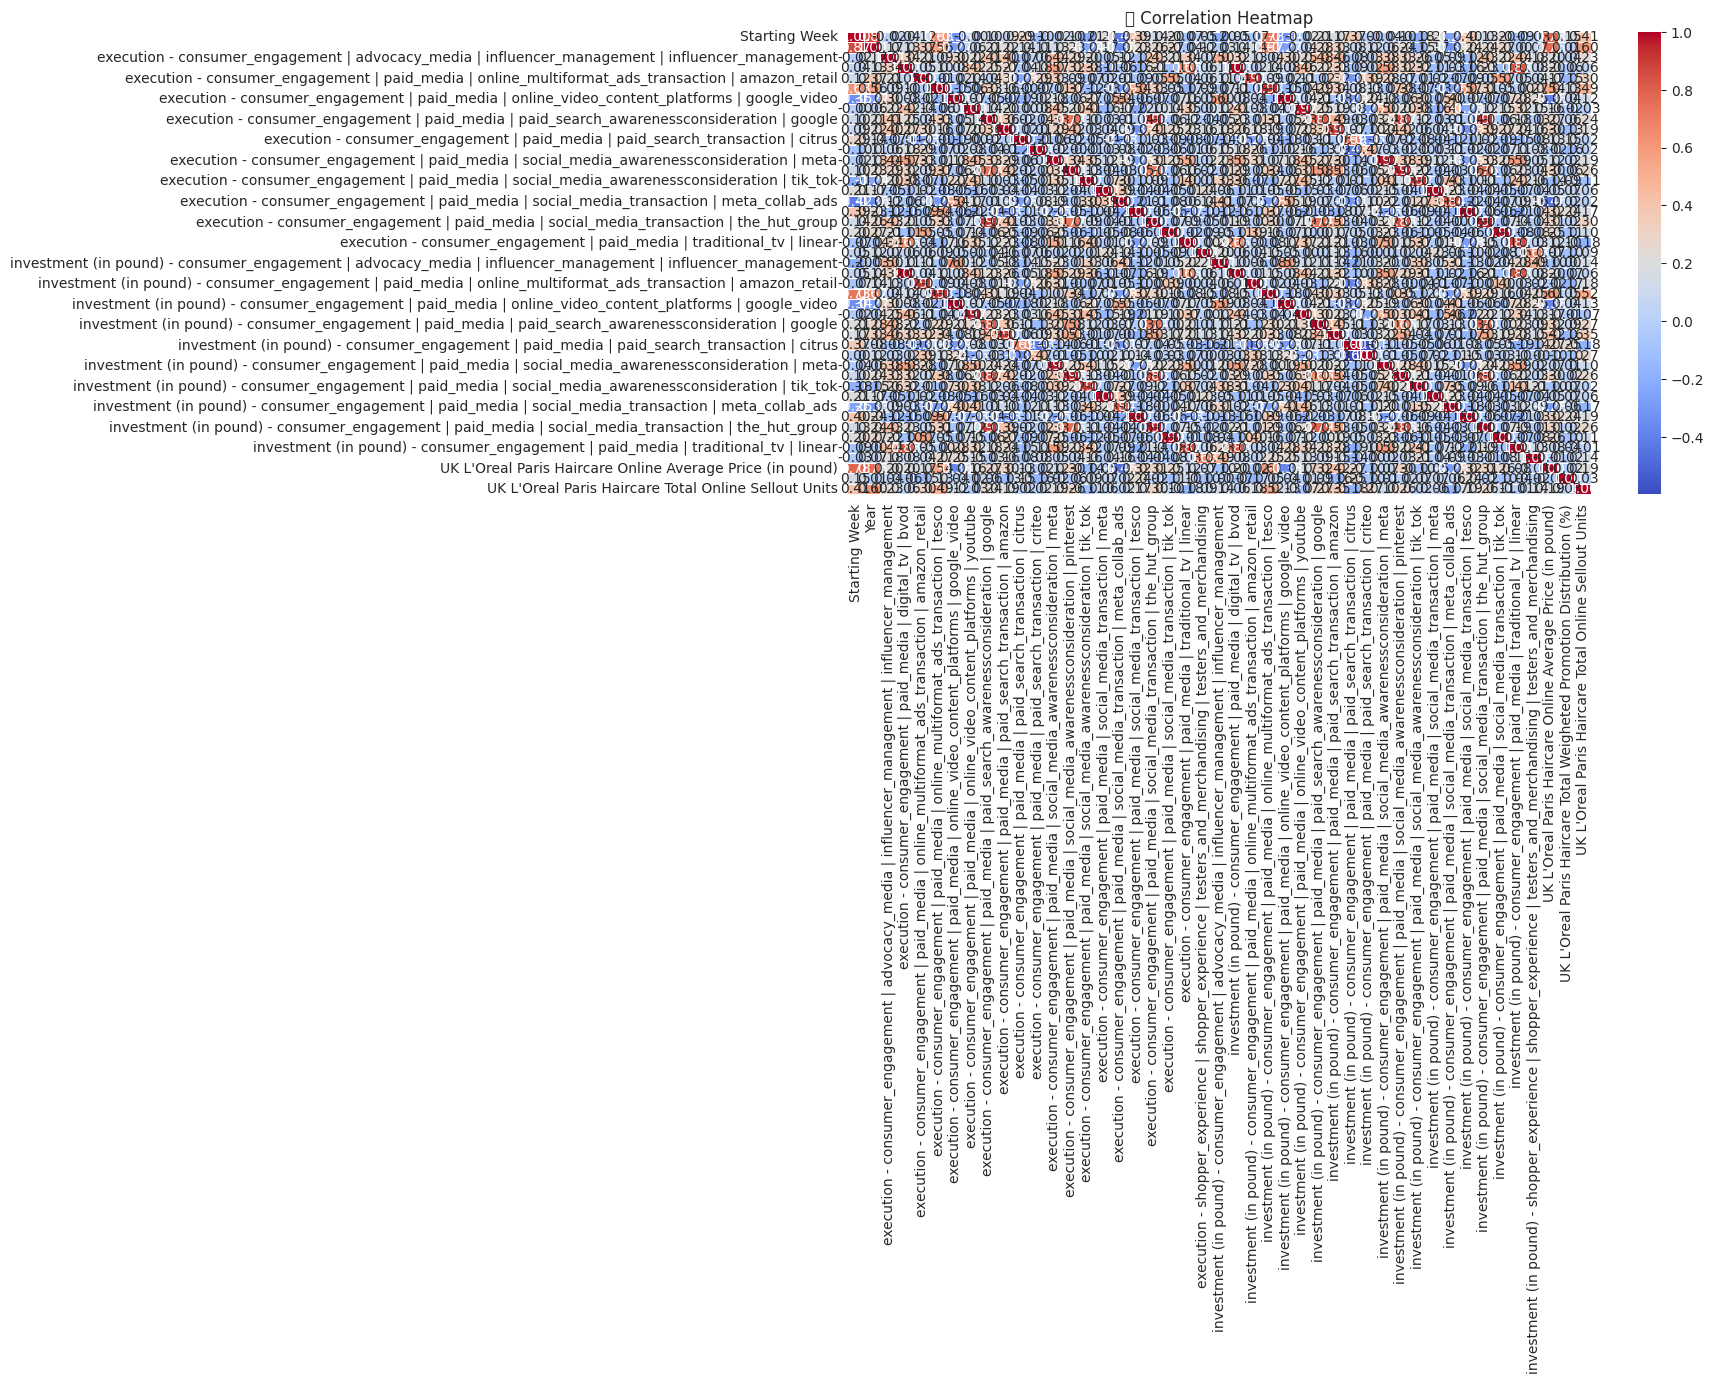

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


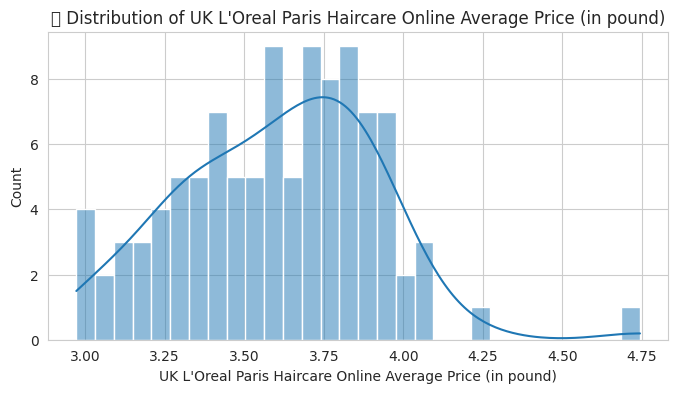

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


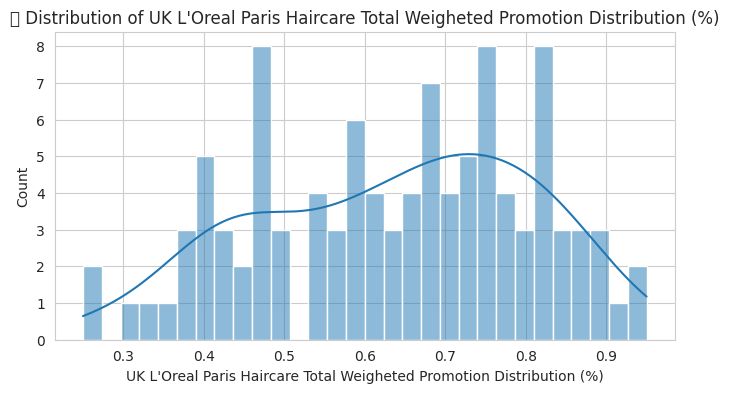

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


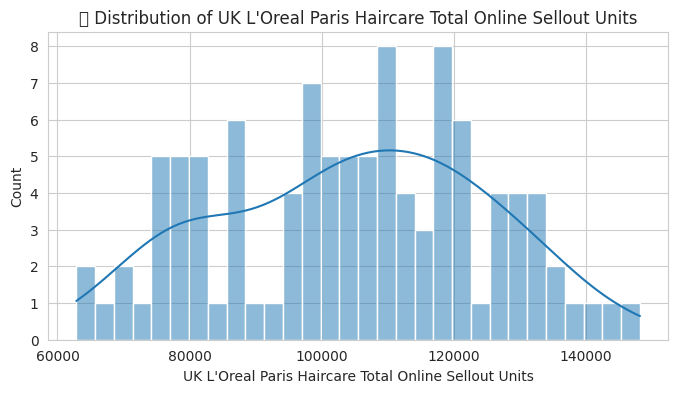

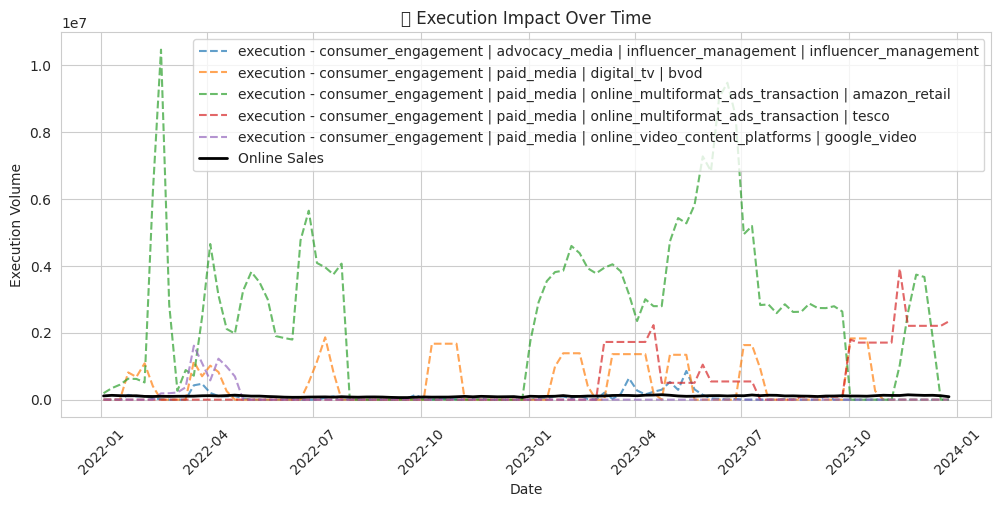

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


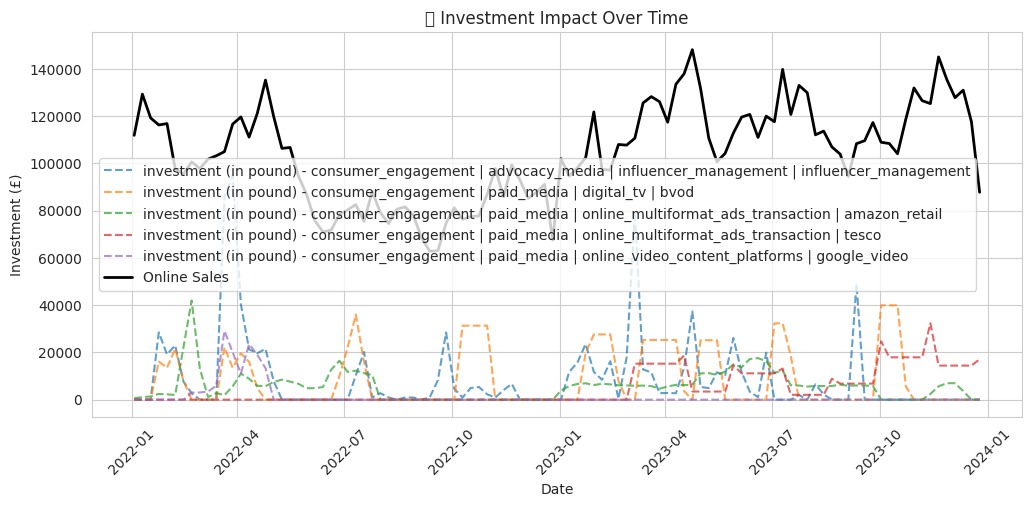

✅ Full EDA Completed!


In [17]:
# Load the cleaned dataset
df = pd.read_csv("online_dataset_cleaned.csv")

# Convert date column to datetime
df["Starting Week"] = pd.to_datetime(df["Starting Week"])

# Set the figure style
sns.set_style("whitegrid")

# ---------------- 1️⃣ BASIC OVERVIEW ----------------
print("\n🔹 Dataset Overview:")
print(f"Shape: {df.shape}")
print("\n🔹 Column Types:")
print(df.dtypes)

# Missing values
print("\n🔹 Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print("\n🔹 Duplicates:", df.duplicated().sum())

# ---------------- 2️⃣ DESCRIPTIVE STATISTICS ----------------
print("\n🔹 Summary Statistics (Numerical Variables):")
print(df.describe())

# ---------------- 3️⃣ TIME SERIES ANALYSIS ----------------
plt.figure(figsize=(12,5))
plt.plot(df["Starting Week"], df["UK L'Oreal Paris Haircare Total Online Sellout Units"], marker="o", linestyle="-", label="Online Sales")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("📈 Online Sales Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# ---------------- 4️⃣ CORRELATION ANALYSIS ----------------
corr_matrix = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔗 Correlation Heatmap")
plt.show()

# ---------------- 5️⃣ DISTRIBUTIONS OF KEY VARIABLES ----------------
numeric_cols = [
    "UK L'Oreal Paris Haircare Online Average Price (in pound)",
    "UK L'Oreal Paris Haircare Total Weigheted Promotion Distribution (%)",
    "UK L'Oreal Paris Haircare Total Online Sellout Units"
]

for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"📊 Distribution of {col}")
    plt.xlabel(col)
    plt.show()

# ---------------- 6️⃣ GROWTH DRIVER IMPACT ANALYSIS ----------------
# Find all execution & investment columns
execution_cols = [col for col in df.columns if "execution" in col]
investment_cols = [col for col in df.columns if "investment" in col]

# Plot execution vs sales
plt.figure(figsize=(12,5))
for col in execution_cols[:5]:  # Limit to first 5 to avoid clutter
    plt.plot(df["Starting Week"], df[col], linestyle="--", alpha=0.7, label=col)

plt.plot(df["Starting Week"], df["UK L'Oreal Paris Haircare Total Online Sellout Units"], color="black", linewidth=2, label="Online Sales")
plt.xlabel("Date")
plt.ylabel("Execution Volume")
plt.title("📊 Execution Impact Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot investment vs sales
plt.figure(figsize=(12,5))
for col in investment_cols[:5]:  # Limit to first 5
    plt.plot(df["Starting Week"], df[col], linestyle="--", alpha=0.7, label=col)

plt.plot(df["Starting Week"], df["UK L'Oreal Paris Haircare Total Online Sellout Units"], color="black", linewidth=2, label="Online Sales")
plt.xlabel("Date")
plt.ylabel("Investment (£)")
plt.title("💰 Investment Impact Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

print("✅ Full EDA Completed!")


### Feature eng

In [18]:
# Load dataset
df = pd.read_csv("online_dataset_cleaned.csv")

# Convert date column to datetime
df["Starting Week"] = pd.to_datetime(df["Starting Week"])

# Drop investment columns (we'll use them later for ROI)
df = df.drop(columns=[col for col in df.columns if "investment" in col])

# Set date as index
df = df.set_index("Starting Week")

# ---------------- 1️⃣ TIME-BASED FEATURES ----------------
df["Year"] = df.index.year
df["Month"] = df.index.month
df["Week"] = df.index.isocalendar().week

# UK Holidays (binary feature)
uk_holidays = holidays.country_holidays('GB')
df["Is_Holiday"] = df.index.to_series().apply(lambda x: 1 if x in uk_holidays else 0)

# ---------------- 2️⃣ LAGS (PAST WEEKS EFFECT) ----------------
lag_features = [col for col in df.columns if "execution" in col]
for col in lag_features:
    for lag in range(1, 5):  # Create 1 to 4-week lags
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# ---------------- 3️⃣ DECAY (EXPONENTIAL WEIGHTED MOVING AVERAGE) ----------------
for col in lag_features:
    df[f"{col}_decay"] = df[col].ewm(span=4, adjust=False).mean()

# ---------------- 4️⃣ SATURATION (Diminishing Returns) ----------------
for col in lag_features:
    df[f"{col}_saturation"] = np.log1p(df[col])  # log transformation for diminishing returns

# ---------------- 5️⃣ ADSTOCK (CARRYOVER EFFECT) ----------------
def adstock(series, alpha=0.7):
    """Apply Adstock transformation with decay factor alpha."""
    result = np.zeros(len(series))
    for i in range(1, len(series)):
        result[i] = series.iloc[i] + alpha * result[i - 1]
    return result

for col in lag_features:
    df[f"{col}_adstock"] = adstock(df[col])

# ---------------- 6️⃣ FINAL TARGET & FEATURES ----------------
# Define target variable
y = df["UK L'Oreal Paris Haircare Total Online Sellout Units"]

# Define features (drop target variable)
X = df.drop(columns=["UK L'Oreal Paris Haircare Total Online Sellout Units"])

# Drop NaN values caused by lags
X = X.dropna()
y = y.loc[X.index]


<ipython-input-18-8f372a72bb4a>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_decay"] = df[col].ewm(span=4, adjust=False).mean()
<ipython-input-18-8f372a72bb4a>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_decay"] = df[col].ewm(span=4, adjust=False).mean()
<ipython-input-18-8f372a72bb4a>:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [19]:
X.head()

,Year,execution - consumer_engagement | advocacy_media | influencer_management | influencer_management,execution - consumer_engagement | paid_media | digital_tv | bvod,execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | amazon_retail,execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco,execution - consumer_engagement | paid_media | online_video_content_platforms | google_video,execution - consumer_engagement | paid_media | online_video_content_platforms | youtube,execution - consumer_engagement | paid_media | paid_search_awarenessconsideration | google,execution - consumer_engagement | paid_media | paid_search_transaction | amazon,execution - consumer_engagement | paid_media | paid_search_transaction | citrus,...,execution - consumer_engagement | paid_media | social_media_awarenessconsideration | meta_adstock,execution - consumer_engagement | paid_media | social_media_awarenessconsideration | pinterest_adstock,execution - consumer_engagement | paid_media | social_media_awarenessconsideration | tik_tok_adstock,execution - consumer_engagement | paid_media | social_media_transaction | meta_adstock,execution - consumer_engagement | paid_media | social_media_transaction | meta_collab_ads_adstock,execution - consumer_engagement | paid_media | social_media_transaction | tesco_adstock,execution - consumer_engagement | paid_media | social_media_transaction | the_hut_group_adstock,execution - consumer_engagement | paid_media | social_media_transaction | tik_tok_adstock,execution - consumer_engagement | paid_media | traditional_tv | linear_adstock,execution - shopper_experience | shopper_experience | testers_and_merchandising | testers_and_merchandising_adstock
Starting Week,,,,,,,,,,,,,,,,,,,,,
2022-01-31,2022,95869.369418,679251.82,619993.4,0.0,0.0,0.0,2134.6,2349322.3,0.0,...,2.504655e+07,0.0,0.0,0.0,4.628569e+06,0.0,0.0,0.0,141.531000,1065.160646
2022-02-07,2022,114872.705000,1086802.86,515611.2,0.0,0.0,0.0,1472.9,2473779.1,0.0,...,3.148565e+07,0.0,0.0,0.0,4.840467e+06,0.0,0.0,0.0,185.001700,1097.571852
2022-02-14,2022,38475.998653,407551.04,6170598.2,0.0,0.0,1133346.5,1618.5,2374671.0,0.0,...,3.817920e+07,0.0,0.0,0.0,4.742274e+06,0.0,0.0,0.0,191.251190,1050.839696
2022-02-21,2022,13678.871785,0.00,10469629.3,0.0,188015.1,4097431.0,2389.4,3484471.9,0.0,...,3.900545e+07,0.0,0.0,0.0,4.700745e+06,0.0,0.0,0.0,133.875833,1123.149730
2022-02-28,2022,0.000000,0.00,2835346.8,0.0,191218.3,2921339.2,3247.4,3222242.4,0.0,...,3.005395e+07,0.0,0.0,0.0,4.264195e+06,0.0,0.0,0.0,93.713083,1171.287468


In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2022-01-31 to 2023-12-25
Columns: 166 entries, Year to execution - shopper_experience | shopper_experience | testers_and_merchandising | testers_and_merchandising_adstock
dtypes: UInt32(1), float64(162), int32(2), int64(1)
memory usage: 129.4 KB


✅ Dropped 39 highly correlated features.


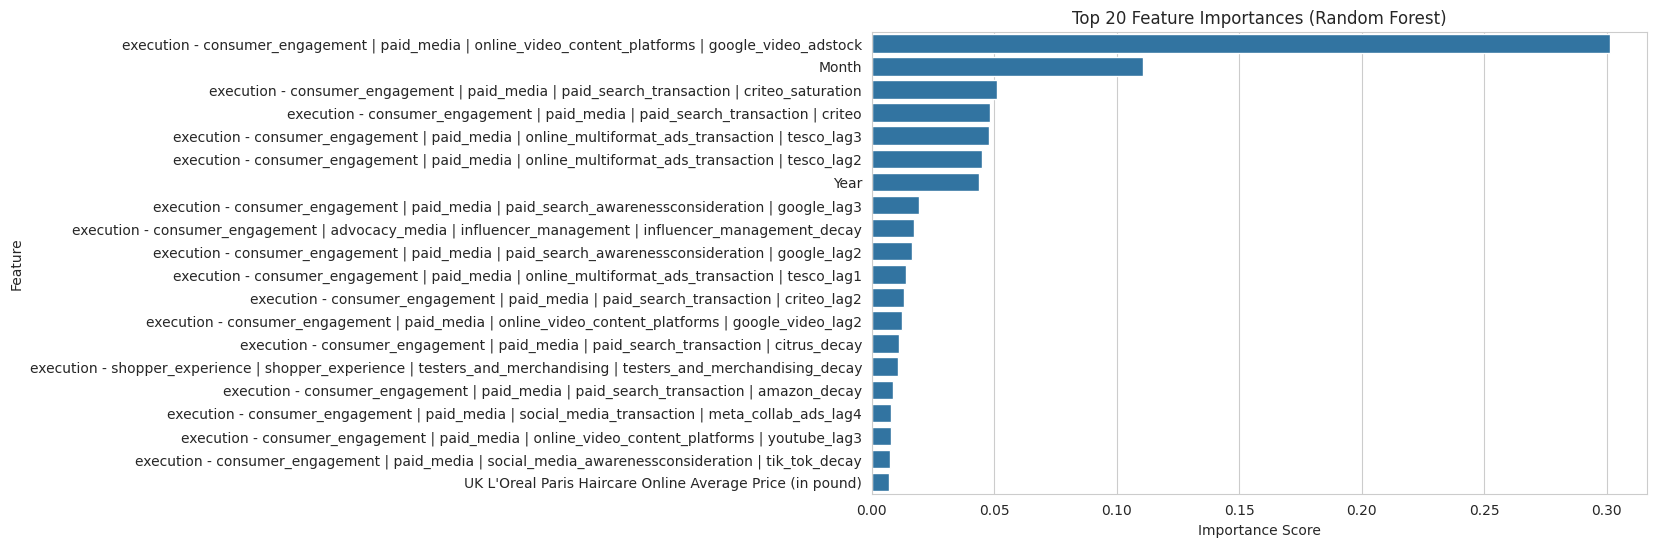

✅ Dropped 112 low-importance features.
✅ Selected 15 best features with RFE.
✅ Feature selection complete. Final dataset saved as 'X_features_selected.csv'.


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=20 > n_features=15. There will be no feature selection and all features will be kept.
  warnings.warn(


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


# ---------------- 1️⃣ REMOVE HIGHLY CORRELATED FEATURES ----------------
corr_matrix = X.corr().abs()

# Find features that are highly correlated
high_corr_pairs = np.where(corr_matrix > 0.9)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j])
                   for i, j in zip(*high_corr_pairs) if i != j]

# Drop one feature from each correlated pair
features_to_drop = set()
for f1, f2 in high_corr_pairs:
    if f1 not in features_to_drop and f2 not in features_to_drop:
        features_to_drop.add(f2)  # Arbitrarily drop the second feature

X_filtered = X.drop(columns=features_to_drop)
print(f"✅ Dropped {len(features_to_drop)} highly correlated features.")

# ---------------- 2️⃣ FEATURE IMPORTANCE (RANDOM FOREST) ----------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_filtered, y.values.ravel())  # Train Random Forest

# Get feature importances
feature_importance = pd.Series(rf.feature_importances_, index=X_filtered.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance[:20], y=feature_importance.index[:20])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Drop features with very low importance (< threshold)
low_importance_features = feature_importance[feature_importance < 0.01].index
X_filtered = X_filtered.drop(columns=low_importance_features)
print(f"✅ Dropped {len(low_importance_features)} low-importance features.")

# ---------------- 3️⃣ RECURSIVE FEATURE ELIMINATION (RFE) ----------------
rfe = RFE(estimator=LinearRegression(), n_features_to_select=20)  # Keep top 20 features
rfe.fit(X_filtered, y.values.ravel())

# Select only the best features
selected_features = X_filtered.columns[rfe.support_]
X_final = X_filtered[selected_features]

print(f"✅ Selected {len(selected_features)} best features with RFE.")

# Save final dataset
X_final.to_csv("X_features_selected.csv")
print("✅ Feature selection complete. Final dataset saved as 'X_features_selected.csv'.")


### Training

In [22]:
y.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 100 entries, 2022-01-31 to 2023-12-25
Series name: UK L'Oreal Paris Haircare Total Online Sellout Units
Non-Null Count  Dtype  
--------------  -----  
100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


In [23]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2022-01-31 to 2023-12-25
Data columns (total 15 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   Year                                                                                                               100 non-null    int32  
 1   execution - consumer_engagement | paid_media | paid_search_transaction | criteo                                    100 non-null    float64
 2   Month                                                                                                              100 non-null    int32  
 3   execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco_lag1                     100 non-null    float64
 4   executi

In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import durbin_watson


# Split into train & test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, shuffle=False)

# ---------------- 1️⃣ OLS REGRESSION (BASELINE) ----------------
X_train_ols = sm.add_constant(X_train)  # Add intercept
X_test_ols = sm.add_constant(X_test, has_constant='add')

ols_model = sm.OLS(y_train, X_train_ols).fit()
y_pred_ols = ols_model.predict(X_test_ols)

# Evaluate OLS
r2_ols = r2_score(y_test, y_pred_ols)
dw_ols = durbin_watson(ols_model.resid)

print("\n🔹 OLS Regression Results:")
print(f"R² Score: {r2_ols:.4f}")
print(f"Durbin-Watson: {dw_ols:.4f}")

# ---------------- 2️⃣ REGULARIZED REGRESSION (RIDGE & LASSO) ----------------
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

r2_ridge = r2_score(y_test, y_pred_ridge)
print("\n🔹 Ridge Regression Results:")
print(f"R² Score: {r2_ridge:.4f}")

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
print("\n🔹 Lasso Regression Results:")
print(f"R² Score: {r2_lasso:.4f}")

# ---------------- 3️⃣ RANDOM FOREST (NON-LINEAR) ----------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.values.ravel())  # Flatten y for sklearn
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
print("\n🔹 Random Forest Results:")
print(f"R² Score: {r2_rf:.4f}")

# ---------------- MODEL COMPARISON ----------------
print("\n📊 Model Performance Comparison:")
print(f"OLS: R² = {r2_ols:.4f}, Durbin-Watson = {dw_ols:.4f}")
print(f"Ridge: R² = {r2_ridge:.4f}")
print(f"Lasso: R² = {r2_lasso:.4f}")
print(f"Random Forest: R² = {r2_rf:.4f}")

# Save model summaries
ols_model.summary()


🔹 OLS Regression Results:
R² Score: -0.7996
Durbin-Watson: 0.9879

🔹 Ridge Regression Results:
R² Score: -0.7300

🔹 Lasso Regression Results:
R² Score: -0.7996

🔹 Random Forest Results:
R² Score: 0.3167

📊 Model Performance Comparison:
OLS: R² = -0.7996, Durbin-Watson = 0.9879
Ridge: R² = -0.7300
Lasso: R² = -0.7996
Random Forest: R² = 0.3167


<class 'statsmodels.iolib.summary.Summary'>
"""
                                             OLS Regression Results                                             
================================================================================================================
Dep. Variable:     UK L'Oreal Paris Haircare Total Online Sellout Units   R-squared:                       0.783
Model:                                                              OLS   Adj. R-squared:                  0.732
Method:                                                   Least Squares   F-statistic:                     15.40
Date:                                                  Thu, 06 Feb 2025   Prob (F-statistic):           8.25e-16
Time:                                                          16:11:44   Log-Likelihood:                -846.22
No. Observations:                                                    80   AIC:                             1724.
Df Residuals:                                                        64   BIC:                             1763.
Df Model:                                                            15                                         
Covariance Type:                                              nonrobust                                         
=====================================================================================================================================================================================
                                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                             -3.812e+07   1.06e+07     -3.610      0.001   -5.92e+07    -1.7e+07
Year                                                                                                               1.889e+04   5223.560      3.617      0.001    8458.032    2.93e+04
execution - consumer_engagement | paid_media | paid_search_transaction | criteo                                      -0.0067      0.003     -2.015      0.048      -0.013   -5.64e-05
Month                                                                                                                80.4411    747.065      0.108      0.915   -1411.993    1572.875
execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco_lag1                        0.0074      0.005      1.596      0.115      -0.002       0.017
execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco_lag2                        0.0063      0.006      1.086      0.281      -0.005       0.018
execution - consumer_engagement | paid_media | online_multiformat_ads_transaction | tesco_lag3                        0.0004      0.005      0.079      0.937      -0.010       0.011
execution - consumer_engagement | paid_media | online_video_content_platforms | google_video_lag2                     0.0108      0.008      1.350      0.182      -0.005       0.027
execution - consumer_engagement | paid_media | paid_search_awarenessconsideration | google_lag2                       0.0006      0.003      0.171      0.865      -0.006       0.007
execution - consumer_engagement | paid_media | paid_search_awarenessconsideration | google_lag3                       0.0028      0.003      0.936      0.353      -0.003       0.009
execution - consumer_engagement | paid_media | paid_search_transaction | criteo_lag2                               4.837e-05      0.002      0.020      0.984      -0.005       0.005
execution - consumer_engagement | advocacy_media | influencer_management | influencer_management_decay               -0.0274      0.016     -1.696      0.095    

In [25]:
import statsmodels.api as sm

# Fit SARIMAX model with exogenous execution variables
sarimax_model = sm.tsa.SARIMAX(
    y,
    exog=X_final,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Predict
y_pred_sarimax = sarimax_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Evaluate
r2_sarimax = r2_score(y_test, y_pred_sarimax)
dw_sarimax = durbin_watson(sarimax_model.resid)

print("\n🔹 SARIMAX Model Results:")
print(f"R² Score: {r2_sarimax:.4f}")
print(f"Durbin-Watson: {dw_sarimax:.4f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



🔹 SARIMAX Model Results:
R² Score: 0.5857
Durbin-Watson: 1.5268


In [26]:
import xgboost as xgb

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n🔹 XGBoost Model Results:")
print(f"R² Score: {r2_xgb:.4f}")



🔹 XGBoost Model Results:
R² Score: 0.2736


In [27]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Reduced parameter space
p = d = q = [0, 1]  # Only test 0 and 1 instead of 0,1,2
P = D = Q = [0, 1]  # Seasonal orders also limited to 0,1
seasonal_period = [52]  # Fixed seasonality (weekly data)

# Generate combinations
param_combinations = list(itertools.product(p, d, q))
seasonal_combinations = list(itertools.product(P, D, Q, seasonal_period))

best_score, best_params = float("inf"), None

# Run grid search
for param in param_combinations:
    for seasonal_param in seasonal_combinations:
        try:
            model = sm.tsa.SARIMAX(
                y,
                exog=X,
                order=param,
                seasonal_order=seasonal_param,
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit()

            # Predict & evaluate on test set
            y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
            mse = mean_squared_error(y_test, y_pred)

            # Keep track of the best model
            if mse < best_score:
                best_score, best_params = mse, (param, seasonal_param)

            print(f"Tested SARIMAX{param}x{seasonal_param} - MSE: {mse:.4f}")

        except:
            continue  # Skip invalid models

print("\n✅ Best SARIMAX Parameters:", best_params)



✅ Best SARIMAX Parameters: None


In [28]:
from statsmodels.tsa.api import VAR

# Combine all execution features and sales
data_var = pd.concat([y] + [X[col] for col in X_final.columns if "execution" in col], axis=1)

# Train VAR model
model_var = VAR(data_var)
var_results = model_var.fit(maxlags=5, ic="aic")

# Forecast
forecast = var_results.forecast(data_var.values[-5:], steps=len(y_test))
r2_var = r2_score(y_test, forecast[:, 0])  # Compare forecasted sales to actual

print("\n🔹 VAR Model Results:")
print(f"R² Score: {r2_var:.4f}")



🔹 VAR Model Results:
R² Score: -5.9093


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
